In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
from IPython import display
import sys

# 1 Data set

We will work again with the Tensorflow Cifar10 dataset. It contains 60.000 coloured images of cells with equal sizes.

Each images corresponds to one of 10 categories. The dataset is already implementedas a keras.dataset module and very convenient to load!

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete7QP3UA/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete7QP3UA/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


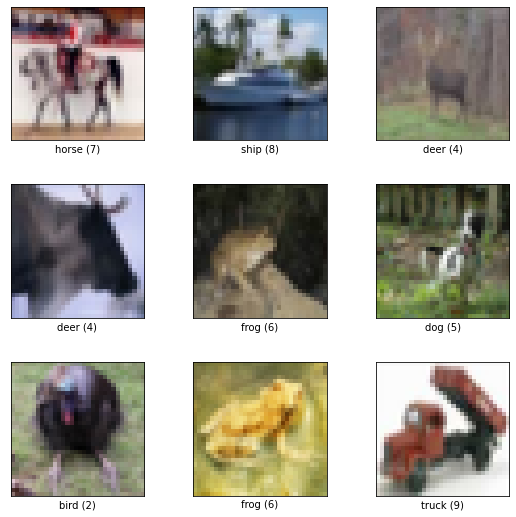

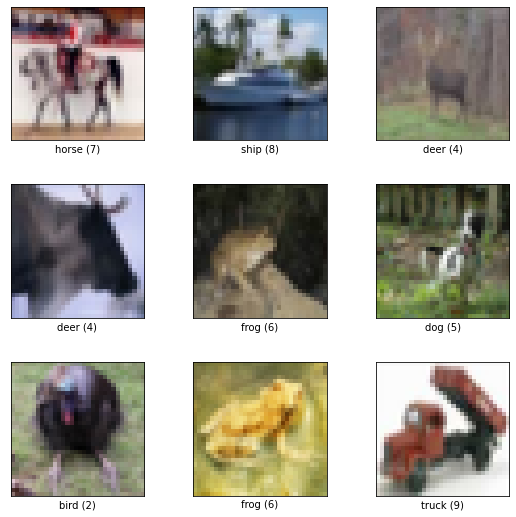

In [ ]:
(ds_raw_train, ds_raw_test), ds_info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)
tfds.show_examples(ds_raw_train, ds_info)

Perform necessary or beneficial preprocessing steps.

- normalize the values of the images, i.e. rescale them to the range [0,1]
> converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value (i.e. 255)
- we use one-hot encoding to easily work with the labels 
> we need 10 digits, because the dataset contains pictures from 10 distinct classes <br>
> therefore we cast the labels into integers


- in the end, we use batching and prefetching to make the further training easier and the runtime faster

In [ ]:
# Dataset
ds_train = ds_raw_train.map(lambda x,y: (tf.cast(2*(x/255)-1, tf.float32), tf.one_hot(tf.cast(y, tf.uint8), 10)))
ds_test = ds_raw_test.map(lambda x,y: (tf.cast(2*(x/255)-1, tf.float32), tf.one_hot(tf.cast(y, tf.uint8), 10)))

# LoadUp
ds_train = ds_train.batch(64).prefetch(64)
ds_test = ds_test.batch(64).prefetch(64)

# 2 Model


## 2.1 ResNet

Start with implementing a callable ResidualBlock class. 
Implement an init function defining the main building blocks: Your residual block should consist of multiple alterations of Convolution and Batch Normaliza-
tion layers. You will need to make sure that the output of the block has the same dimensions as its input. 

Implement a call function.

Here, we define what is inside every residual Block. Every Block is constructed equally and all follow straight after each other. <br>
Only separated by the information of the last block, which additionally gets added after the data ran through the current block 

- Every Block starts with a convolutional layer, whose filter- and kernelsize gets passed from the ResNet class


In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
  """It's a block... and its residual... u know"""

  def __init__(self, filterlist, kernel_sizes):
    """We define the properties of our residual Block. These are the layers that get skipped by the shortcut defined in the call function"""
    super(ResidualBlock, self).__init__()

    self.layers = []
    for filter, kernel in zip(filterlist, kernel_sizes):
      self.layers.append(tf.keras.layers.Conv2D(filter,kernel,padding='same', activation=None))
      # , kernel_regularizer=tf.keras.regularizers.l2(1e-4)
      self.layers.append(tf.keras.layers.BatchNormalization())
      self.layers.append(tf.keras.layers.Activation(tf.keras.activations.relu))
      
     

  @tf.function
  def call(self, x, training=True):
    """We save the original input and call every layer in the block making sure that when calling batch normalization we also give the training boolean.
    In the next step, we add an identity mapping by shortcuts, which is the core of our ResNet"""
    y = x
    # performed 162 times (6 Blocks * 3 Layers * 3 Blocks)
    for i, layer in enumerate(self.layers):
      #print("Layer: ", self.layers)
      #print(i)
      if i % 3 == 1:
        y = layer(y, training)
      else:
        y = layer(y)

    # y = self.conv(y)
    # y = self.batchnorm(y, training)
    # y = self.acti(y)

    y = y+x
    
    return y

Implement a callable ResNet class, consisting of a convolutional layer followed by
multiple Residual Blocks and an output layer. 

To further explore your networks behaviour, it might be convenient to implement
it in a way that you can easily alter the number of Residual Blocks. 

Implement the networks call function.

- In the beginning a convolutional layer, through which all information passes; without any skipping or leftover
- The main part consists of the residual Blocks
> every residual Block consists of what is defined in the class "ResidualBlock" above
- We use a pooling layer in the end, to reduce the spacital size of the representation in order to reduce the amount of parameters and therefore also computation in the network; Followed by an output layer

In [ ]:
class ResNet(tf.keras.Model):

  def __init__(self,  num_blocks=6, filterlist=[128,128,64,64], kernel_sizes=[3,3,3,1]):
    super(ResNet, self).__init__()

    self.conv = tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same')

    self.blocks = []
    for filter, kernel in zip([filterlist] * num_blocks, [kernel_sizes] * num_blocks):
      self.blocks.append(ResidualBlock(filter, kernel))
    
    self.post_block = []

    self.post_block.append(tf.keras.layers.GlobalAveragePooling2D())
    self.post_block.append(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax))
  

  @tf.function
  def call(self, x, training=True):
    x = self.conv(x)
    
    for block in self.blocks:
      x = block(x, training)
      
    for layer in self.post_block:
      x = layer(x)

    return x
    

## 2.2 DenseNet

Start with the Implementation of a callable class for your Transition Layers.
> The Layer between two adjacent blocks; They change the feature map size and therefore decrease the channel depth

In [ ]:
class TransitionLayer(tf.keras.layers.Layer):

  def __init__(self, filters=64):
    super(TransitionLayer, self).__init__()
    self.conv_1 = tf.keras.layers.Conv2D(filters= 3,
                                       kernel_size = 1,
                                       padding = 'same',
                                       activation=None,
#                                       kernel_regularizer=tf.keras.regularizers.l2(1e-4)
                                       )
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.activation_relu_1 = tf.keras.layers.Activation(tf.keras.activations.relu)

    self.av_pool = tf.keras.layers.AveragePooling2D(strides=(2,2))



  @tf.function
  def call(self, x, training=True):

    x = self.conv_1(x)
    x = self.batch_norm_1(x, training)
    x = self.activation_relu_1(x)

    x = self.av_pool(x)

    return x

You may want to implement a subclass Block containing the convolution layer and the concatenation implemented in the call function.

> Here, we define what is inside every step of the Dense Block, such that we can call it multiple times to build a whole Dense Block.

> Use concatenation to "stack" all the previous outputs onto all levels behind

In [ ]:
class Block(tf.keras.layers.Layer):

  def __init__(self, filter, kernel):
    super(Block, self).__init__()

    self.conv_1 = tf.keras.layers.Conv2D(filter,
                                       kernel,
                                       padding = 'same',
                                       activation=None,
    #                                   kernel_regularizer=tf.keras.regularizers.l2(1e-4)
                                       )
    self.batch_norm_1 = tf.keras.layers.BatchNormalization()
    self.activation_relu_1 = tf.keras.layers.Activation(tf.keras.activations.relu)

    self.concat = tf.keras.layers.Concatenate()
  
  
  @tf.function
  def call(self, x, training=True):
    y = x
        
    y = self.conv_1(y)
    y = self.batch_norm_1(y, training)
    y = self.activation_relu_1(y)
    y = self.concat([y,x])

    return y

Implement the Dense Block class. Remember, a Dense Block is a series of convolutions where the original input is concatenated with the output of the convolution
operation. 

Implement your Dense Block class in a way that you can easily alter the number
of Dense Blocks you want to use.

> Now, build a class to define the whole Dense Block itself; Calling the "Block" class again to get what happens at every Layer in the Block

In [ ]:
class DenseBlock(tf.keras.layers.Layer):

  def __init__(self, filterlist=[64,128,128,32], kernel_sizes=[3,3,3,3]):
    super(DenseBlock, self).__init__()

    self.layers = []
    for filter, kernel in zip(filterlist, kernel_sizes):
      self.layers.append(Block(filter,kernel))


  @tf.function
  def call(self, x , training=True):

    for layer in self.layers:
      x = layer(x, training)
      
    return x


Implement the DenseNet class.

- You will want to have a set of layers before your Dense Blocks fixing the
desired channel dimension you need to pass on to the Dense Blocks.
- You will want to consecutively alter Dense Blocks and Transition Layers. 
Remember the use of the growth rate when creating the Transition Layer
instances. 
- After the last Dense Block make sure to include a proper set of output layers.


Implement the respective call function.

In [ ]:
class DenseNet(tf.keras.Model):

  def __init__(self, num_blocks=4):
    super(DenseNet, self).__init__()

    self.pre_conv = tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, padding='same', activation=None, kernel_regularizer=tf.keras.regularizers.l2(1e-4))
    self.pre_bn = tf.keras.layers.BatchNormalization()
    self.pre_relu = tf.keras.layers.Activation(tf.keras.activations.relu)
     
    self.blocks = [DenseBlock()]
    for block in range(num_blocks - 1):
      self.blocks.append(TransitionLayer())
      self.blocks.append(DenseBlock())
      
    self.post_bn = tf.keras.layers.BatchNormalization()
    self.post_pool = tf.keras.layers.GlobalAveragePooling2D()
    self.post_dense = tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)

  
  @tf.function
  def call(self, x, training=True):
    #print('start', x.shape)
    x = self.pre_conv(x)
    x = self.pre_bn(x, training)
    x = self.pre_relu(x)
    #print('after pre: ', x)
    for block in self.blocks:
      x = block(x, training)

    x = self.post_bn(x, training)
    x = self.post_pool(x)
    x = self.post_dense(x)

    return x


# 3 Training

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input,training=True)
    loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)
    accuracy = np.mean(np.argmax(target,axis=1)==np.argmax(prediction,axis=1))
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss, accuracy

def test(model, test_data, loss_function):
  # test over complete test data
  test_accuracy_aggregator = []
  test_loss_aggregator = []

  
  for (input, target) in test_data:
    prediction = model(input,training=False)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy = np.mean(np.argmax(target,axis=1)==np.argmax(prediction,axis=1))
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
def visualize(test_losses, train_losses, test_accuracies, train_accuracies):
  """This method first clears the output of the cell and then print out 2 plots. One for the test and training loop and one for the test accuracy.
  When called in a for loop it kind of animates the progress within the for loop."""
  display.clear_output(wait=True)
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,5))
  fig.suptitle('Training')
  ax1.title.set_text("Loss for training and test data")
  ax1.plot(test_losses, label='Test losses')
  ax1.plot(train_losses, label='Train losses')
  ax1.legend()
  ax1.grid()

  ax2.title.set_text("Performance on test data :" + str(round(test_accuracies[-1] * 100, 2)) + "%\n Performance on training data :"+ str(round(train_accuracies[-1] * 100, 2)) + "%")
  ax2.plot(test_accuracies, label='Test accuracy')
  ax2.plot(train_accuracies, label='Train accuracy')
  ax2.legend()
  ax2.grid()
  plt.show()

In [ ]:
def train_model(model, num_epochs=10):

  tf.keras.backend.clear_session()
  
  # Datasets
  global ds_test
  global ds_train
  ### Hyperparameters
  learning_rate = 0.0007
  running_average_factor = 0.95
  # Initialize the loss: Categorical Crossentropy. Check out 'tf.keras.losses'.
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
  # Initialize the optimizer: Adam
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # Initialize lists for later visualization.
  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []
  start = time.time()

  #testing once before we begin
  test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)
  print("Accuracy on test data before any training: ", test_accuracy)
  print("Loss on test data before any training: ", test_loss, "\n")

  #check how model performs on train data once before we begin
  train_loss, train_accuracy = test(model, ds_train, cross_entropy_loss)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # We train for num_epochs epochs.
  for epoch in range(num_epochs):
      print('Currently running epoch: __ ' + str(epoch + 1))

      ds_train = ds_train.shuffle(buffer_size=64).prefetch(tf.data.experimental.AUTOTUNE)
      ds_test = ds_test.shuffle(buffer_size=64).prefetch(tf.data.experimental.AUTOTUNE)


      #training (and checking in with training)
      running_average_loss = 0
      running_average_accuracy = 0
      for (input,target) in ds_train:
          train_loss, train_accuracy = train_step(model, input, target, cross_entropy_loss, optimizer)
          running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
          running_average_accuracy = running_average_factor * running_average_accuracy  + (1 - running_average_factor) * train_accuracy
      train_losses.append(running_average_loss)
      train_accuracies.append(running_average_accuracy)
      # glimpse at performance during training
      # print('Training accuracy: ' + str(train_accuracies[-1]))

      #testing
      test_loss, test_accuracy = test(model, ds_test, cross_entropy_loss)
      test_losses.append(test_loss)
      test_accuracies.append(test_accuracy)
      # glimpse at performance after training, on test data
      # print('Test accuracy: ' + str(test_accuracies[-1]))
      
      # glimpse at performance after training, on test data
      visualize(test_losses, train_losses, test_accuracies, train_accuracies)
      print('Elapsed time:  '+ str(round((time.time() - start), 2)) + ' s \n')

  model.summary()

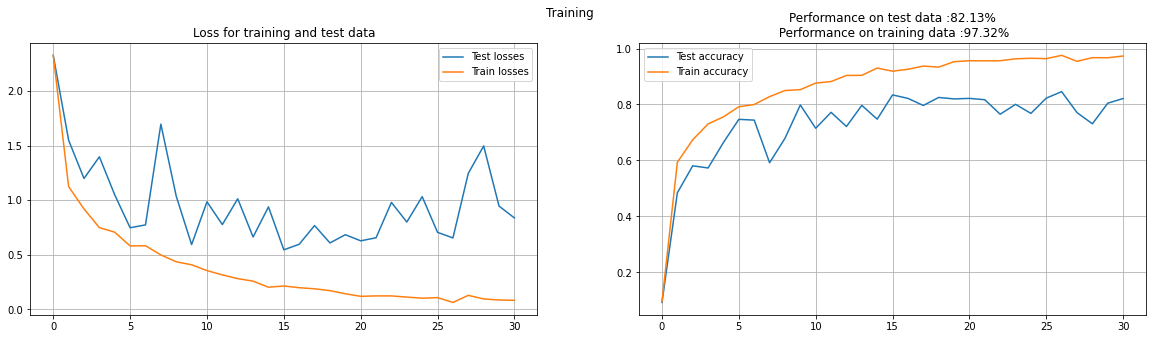

Elapsed time:  4566.4 s 

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
residual_block (ResidualBloc multiple                  300928    
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  300928    
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  300928    
_________________________________________________________________
residual_block_3 (ResidualBl multiple                  300928    
_________________________________________________________________
residual_block_4 (ResidualBl multiple                  300928    
_________________________________________________________________
residual_block_5 (ResidualBl mult

In [ ]:
train_model(ResNet(), 30)

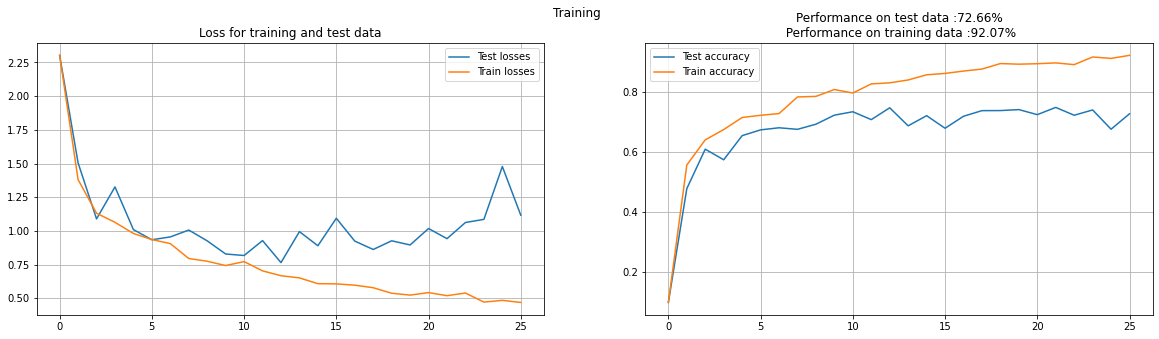

Elapsed time:  2106.06 s 

Model: "dense_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1792      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dense_block (DenseBlock)     multiple                  591584    
_________________________________________________________________
transition_layer (Transition multiple                  1263      
_________________________________________________________________
dense_block_1 (DenseBlock)   multiple                  398336    
_________________________________________________________________
transition_layer_1 (Transiti m

In [ ]:
train_model(DenseNet(), 25)